In [1]:
# !pip install segmentation-models-pytorch

In [2]:
# !pip install torchsummary

In [3]:
# pip install opencv-contrib-python

In [4]:
#!pip install torch=="1.13.1+cu116"  --extra-index-url https://download.pytorch.org/whl/cu116 --user

In [5]:
#!pip show torch

In [6]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [7]:
df = pd.read_csv('list.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   width     28594 non-null  int64 
 2   height    28594 non-null  int64 
 3   class     28594 non-null  object
 4   xmin      28594 non-null  int64 
 5   ymin      28594 non-null  int64 
 6   xmax      28594 non-null  int64 
 7   ymax      28594 non-null  int64 
 8   mask      28594 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [9]:
IMG_PATH = '720p'
MASK_PATH = 'mask'

In [10]:
print(IMG_PATH + df.filename[0]) 

720pimage00000001.jpg


In [11]:
list_of_images = sorted([i for i in Path(IMG_PATH).iterdir()])
list_of_masks = sorted([i for i in Path(MASK_PATH).iterdir()])

len(list_of_images), len(list_of_masks)

(28594, 28540)

In [12]:
df = df.loc[df['mask'].isin([i.name for i in list_of_masks])]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   width     28540 non-null  int64 
 2   height    28540 non-null  int64 
 3   class     28540 non-null  object
 4   xmin      28540 non-null  int64 
 5   ymin      28540 non-null  int64 
 6   xmax      28540 non-null  int64 
 7   ymax      28540 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [13]:
class LipsDataset(Dataset):
    def __init__(self, df, preprocessing=None):
        self.df = df
        self.images = df['filename']
        self.masks = df['mask']
        self.preprocessing = preprocessing
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(IMG_PATH + '/' + self.images[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (160, 96))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img, dtype=torch.float32) / 255
        
        img = img.permute(2, 0, 1)
        
        mask = cv2.cvtColor(cv2.imread(MASK_PATH + '/' + self.masks[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (160, 96))
        mask = torch.as_tensor(mask, dtype=torch.uint8) / 255
        mask = mask.permute(2, 0, 1)
        mask = mask[1, :, :]
        mask = mask > 0.2
        mask = mask.int()
        
        return (img.float(), mask)
    
    def __len__(self):
        return len(self.df)

In [14]:
BACKBONE = 'mobilenet_v2'
segmodel1 = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel1.cuda()
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 96, 160]) torch.Size([96, 160])


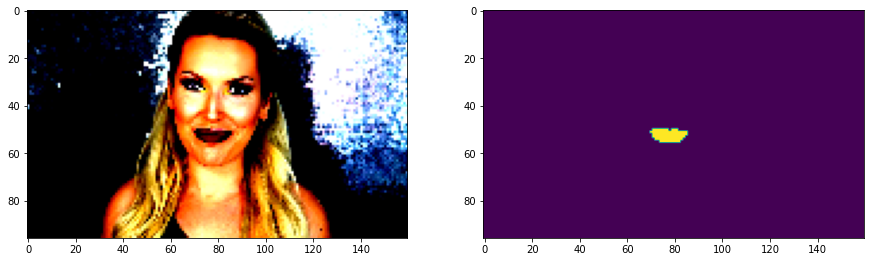

In [15]:
dataset = LipsDataset(df, preprocessing=preprocess_input)
img, masks = dataset[78]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(0, 1))
plt.show()

In [16]:
X_train, X_valid = train_test_split(df, test_size=0.2, random_state=1234)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [17]:
train_dl = DataLoader(train_data, batch_size=100, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=0)

In [18]:
class MyDiceLoss(smp.utils.base.Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        #self.activation = smp.utils.base.modules.Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        #y_pr = self.activation(y_pr)
        return 1 - smp.utils.functional.f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        ) / len(y_pr)

criterion = MyDiceLoss()
# tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='binary', threshold=0.5)
metrics = [smp.utils.metrics.IoU(activation=None), ]
optimizer = optim.Adam(segmodel1.parameters(), lr=0.1)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [20]:
torch.cuda._is_compiled()

True

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel1, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel1, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [22]:
def draw_images(img, mask, pred_mask):
    fig, ax = plt.subplots (1, 3, figsize=(17, 5))
    
    ax[0].imshow(img.cpu().permute(1, 2, 0))
    ax[0].set_title('Image')
    
    ax[1].imshow(mask.cpu().permute(0, 1))
    ax[1].set_title('Mask')
    
    ax[2].imshow(pred_mask.detach().cpu().permute(1, 2, 0))
    ax[2].set_title('Predicted Mask')
    
    plt.show()

In [23]:
def evaluate_model(model, loader, device, criterion):
    loss = 0.0
    model.eval()
    with torch.no_grad():
        for data, label in loader:
            batch_loss = 0.0
            data, label = data.to(device), label.to(device)
            
            output = model(data)
            #for i in range(len(output)):
            #    batch_loss += criterion(output[i], label[i]).item()
            #    
            #loss += batch_loss / len(output)
            loss += criterion(output, label).item()
    #        break
            
    val_loss = loss / len(loader)
    
    print(f'val_loss: {val_loss:.3f}', end='\n')
    #print(loss)
    
    idx = np.random.randint(len(data))
    #print(output[idx][output[idx] < 0])
    #print(label[idx][label[idx] < 0])
    #print(output[idx])
    draw_images(data[idx], label[idx], output[idx])
    
    model.train()
    return loss / len(loader)

In [24]:
#evaluate_model(segmodel1, valid_dl, device, criterion)

In [25]:
def epoch_training(model, criterion, optimizer, train_set, device):
    
    running_loss = 0.0
    
    n_steps = len(train_set)
    steps_n_signs = len(str(n_steps))
    
    for i, data in enumerate(train_set):
        start_time = time.time()
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        epoch_loss = running_loss / (i + 1)
        
        step_duration = time.time() - start_time
        duration = step_duration * n_steps

        print(
            '\r' \
            f'step [{str(i + 1).zfill(steps_n_signs)}/{n_steps}] ' \
            f'- loss: {epoch_loss:.4f} ',
            end='', flush=True)
    
    return epoch_loss


def model_training(model, criterion, optimizer, epochs, device, train_set, valid_set=None):
    history = {
        'loss': []
    }
    if valid_set:
        history['val_loss'] = []
    
    for epoch in range(epochs):

        model.train()
        start_time = time.time()
        
        print(
            f'Epoch {epoch + 1}/{epochs}', 
            end='\n')
        
        epoch_loss = epoch_training(model, criterion, optimizer, train_set, device)
        
        duration = round(time.time() - start_time)
        
        if valid_set:
            val_loss = evaluate_model(model, valid_set, device, criterion)
            history['val_loss'].append(val_loss)
        
        history['loss'].append(epoch_loss)
        
        print(
            '\n' \
            f'duration: {duration}s ({round((duration/len(train_set)) * 1000)}ms/step)\n', 
            end='\n')

    print('Training is finished!')
    
    return history

Epoch 1/25
step [229/229] - loss: 0.8682 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.858


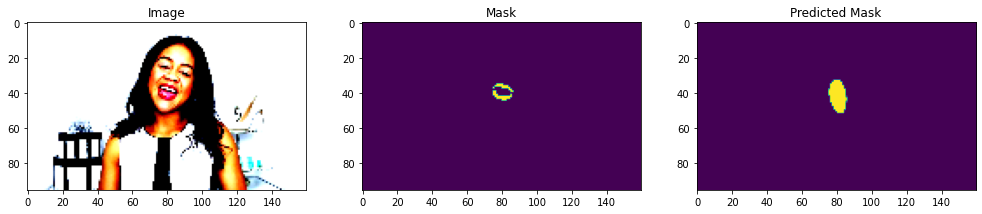


duration: 954s (4166ms/step)

Epoch 2/25
step [229/229] - loss: 0.8577 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.859


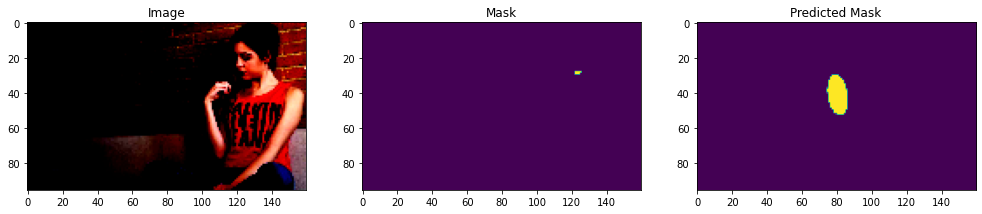


duration: 987s (4310ms/step)

Epoch 3/25
step [229/229] - loss: 0.8564 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.863


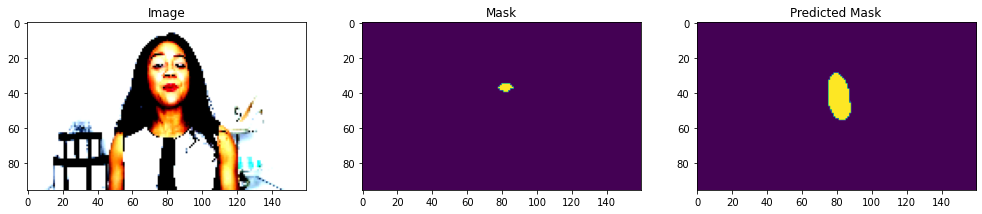


duration: 985s (4301ms/step)

Epoch 4/25
step [229/229] - loss: 0.8564 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.857


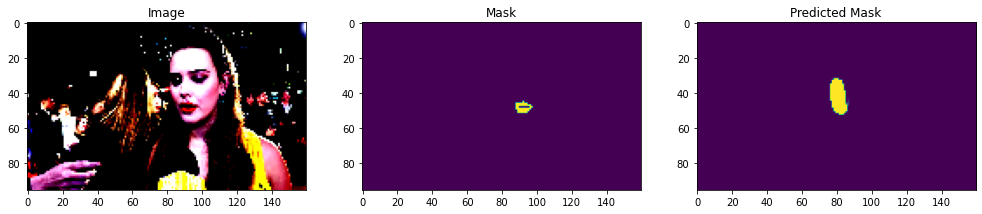


duration: 988s (4314ms/step)

Epoch 5/25
step [229/229] - loss: 0.8557 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.856


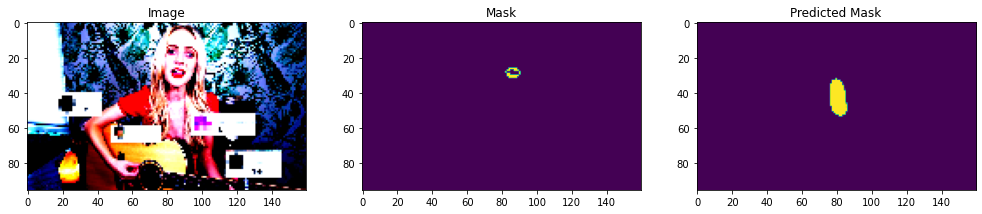


duration: 991s (4328ms/step)

Epoch 6/25
step [229/229] - loss: 0.8548 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.854


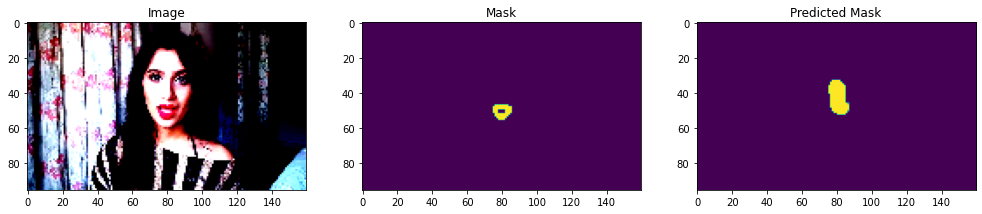


duration: 997s (4354ms/step)

Epoch 7/25
step [229/229] - loss: 0.8547 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


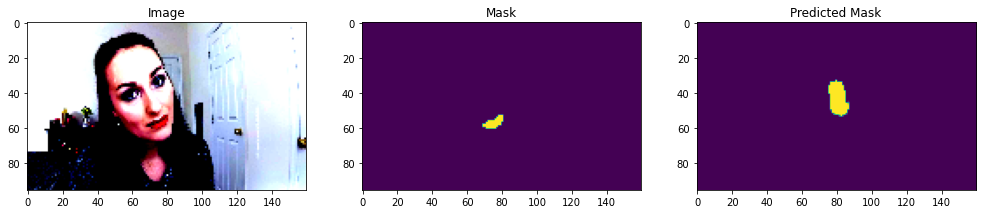


duration: 997s (4354ms/step)

Epoch 8/25
step [229/229] - loss: 0.8537 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


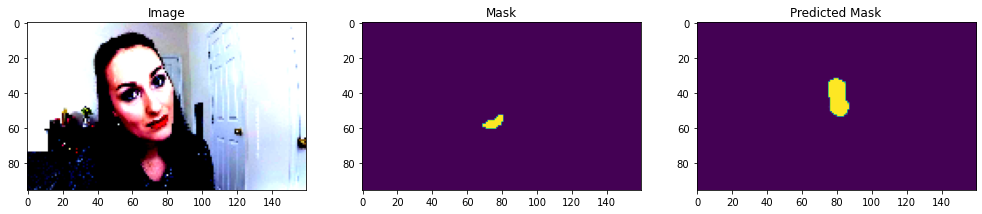


duration: 999s (4362ms/step)

Epoch 9/25
step [229/229] - loss: 0.8552 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 1.000


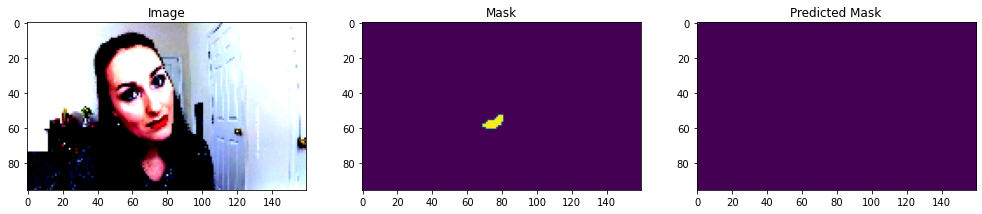


duration: 1001s (4371ms/step)

Epoch 10/25
step [229/229] - loss: 0.8543 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


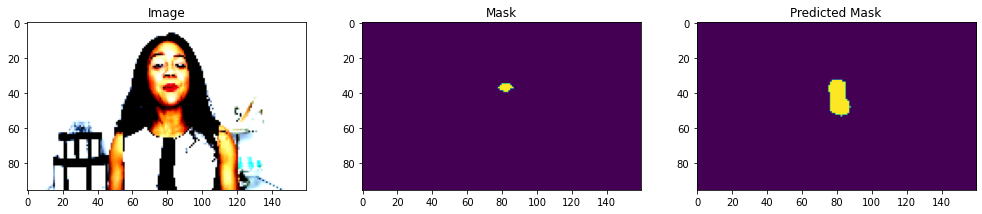


duration: 995s (4345ms/step)

Epoch 11/25
step [229/229] - loss: 0.8541 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.856


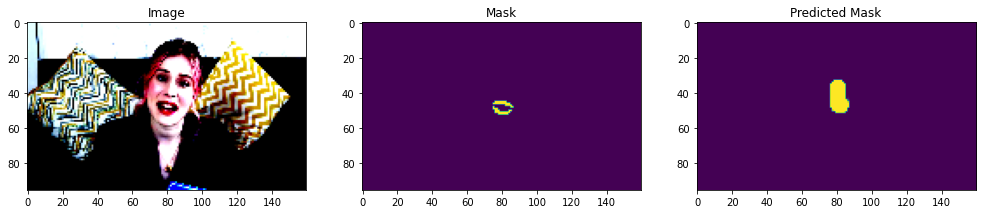


duration: 991s (4328ms/step)

Epoch 12/25
step [229/229] - loss: 0.8538 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.856


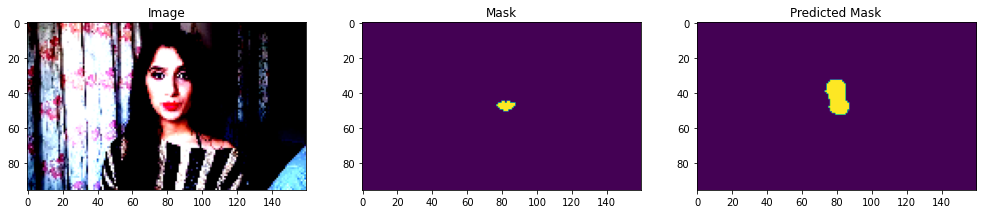


duration: 993s (4336ms/step)

Epoch 13/25
step [229/229] - loss: 0.8536 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


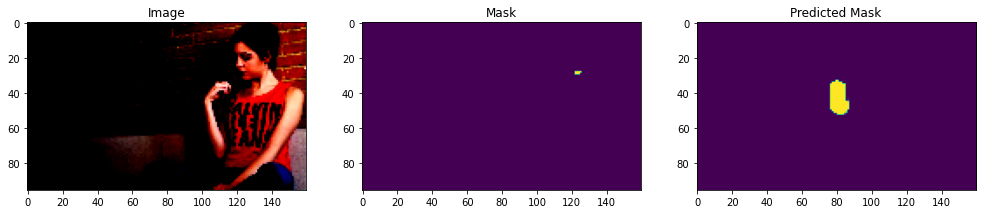


duration: 981s (4284ms/step)

Epoch 14/25
step [229/229] - loss: 0.8539 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.854


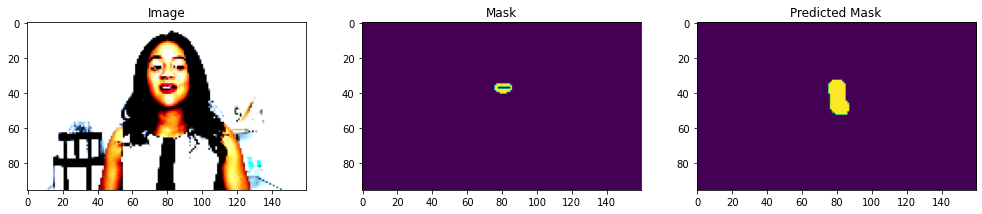


duration: 994s (4341ms/step)

Epoch 15/25
step [229/229] - loss: 0.8544 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


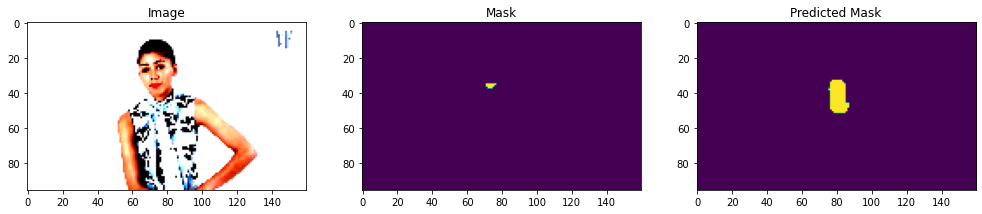


duration: 985s (4301ms/step)

Epoch 16/25
step [229/229] - loss: 0.8537 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.856


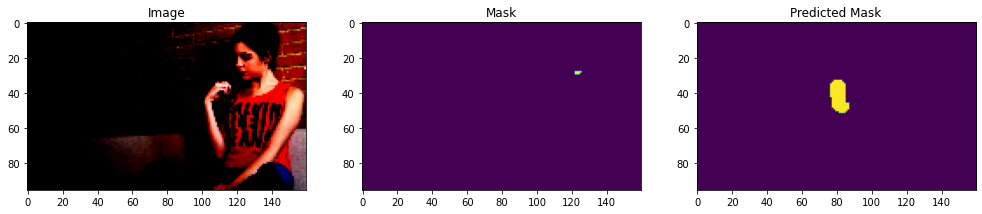


duration: 983s (4293ms/step)

Epoch 17/25
step [229/229] - loss: 0.8539 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.854


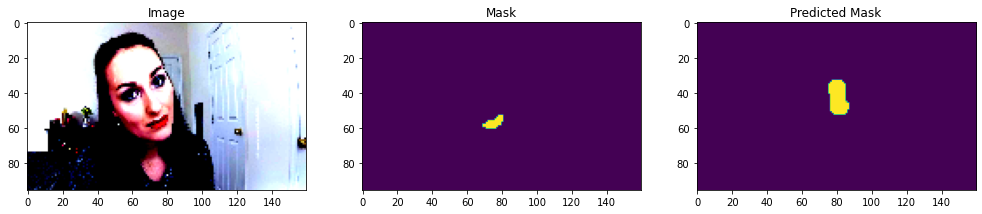


duration: 990s (4323ms/step)

Epoch 18/25
step [229/229] - loss: 0.8537 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.862


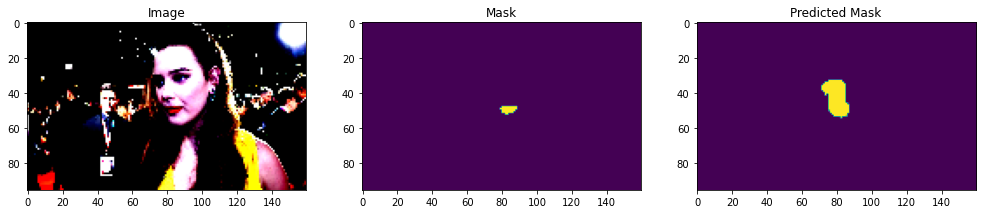


duration: 998s (4358ms/step)

Epoch 19/25
step [229/229] - loss: 0.8540 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


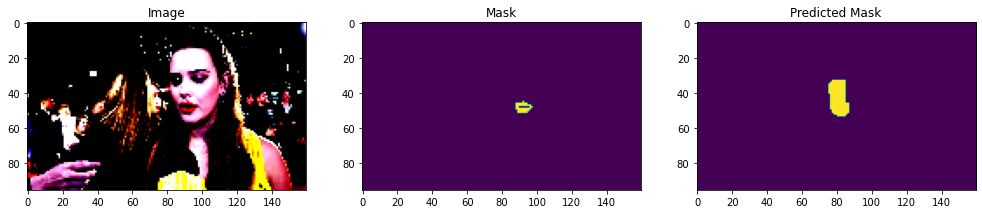


duration: 980s (4279ms/step)

Epoch 20/25
step [229/229] - loss: 0.8549 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.859


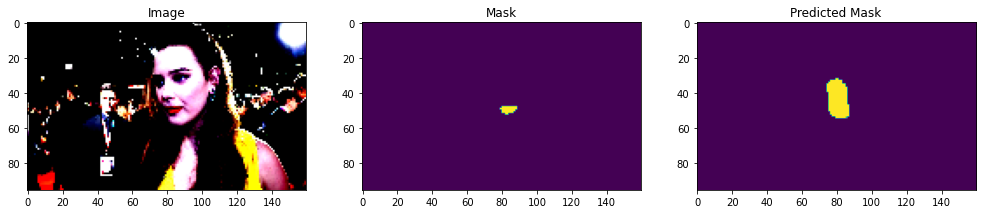


duration: 992s (4332ms/step)

Epoch 21/25
step [229/229] - loss: 0.8539 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


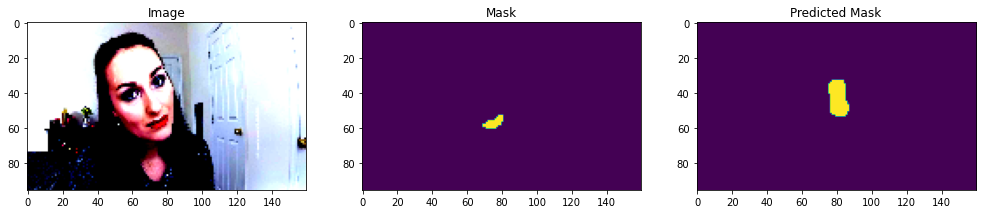


duration: 985s (4301ms/step)

Epoch 22/25
step [229/229] - loss: 0.8537 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


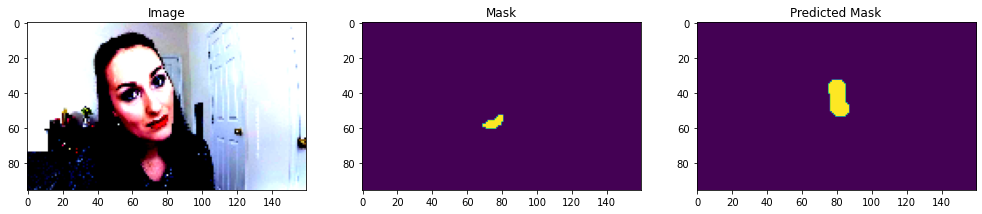


duration: 995s (4345ms/step)

Epoch 23/25
step [229/229] - loss: 0.8536 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


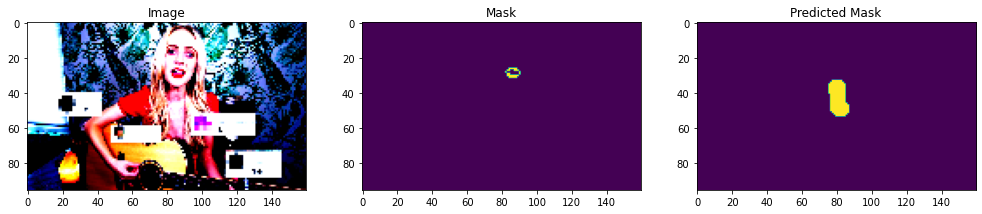


duration: 989s (4319ms/step)

Epoch 24/25
step [229/229] - loss: 0.8535 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


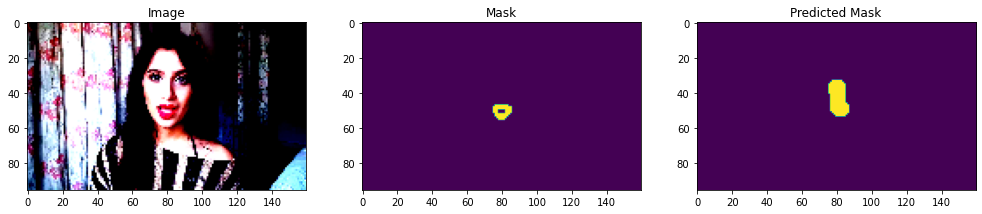


duration: 994s (4341ms/step)

Epoch 25/25
step [229/229] - loss: 0.8536 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val_loss: 0.855


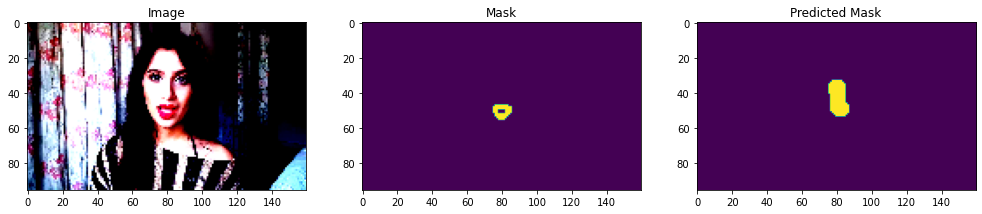


duration: 985s (4301ms/step)

Training is finished!


In [26]:
history = model_training(segmodel1, 
                         criterion, 
                         optimizer, 
                         epochs=25, 
                         device=device, 
                         train_set=train_dl, 
                         valid_set=valid_dl)

In [27]:
# max_score = 0

# segmodel1 = torch.load('./best_model.pth')

# for i in range(0, 5):
#     print(f'Epoch: {i + 1}')
#     train_logs = train_epoch.run(train_dl)
#     valid_logs = valid_epoch.run(valid_dl)
    
#     print(train_logs)
#     print(valid_logs)
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(segmodel1, './best_model.pth')
#         print('Model saved!')